🧪 RUNNING CORRECTNESS TESTS...
✅ CORRECTNESS TESTS PASSED

🚀 STARTING PERFORMANCE BENCHMARKS
Running quick benchmark example...
Starting attention benchmarking...
Causal: True, Heads: 4, Trials: 3
------------------------------------------------------------
Testing B=2, S=512, H=64
  Triton: 0.241ms, PyTorch: 0.323ms, Speedup: 1.34x
Testing B=2, S=1024, H=64
  Triton: 0.261ms, PyTorch: 0.958ms, Speedup: 3.68x

BENCHMARK SUMMARY
Average Execution Time:
  Triton:  0.251 ms
  PyTorch: 0.641 ms

Speedup Statistics:
  Average: 2.51x
  Maximum: 3.68x
  Minimum: 1.34x

Average Memory Usage:
  Triton:  339.3 MB
  PyTorch: 362.4 MB
  Memory Ratio: 1.07x

Best Configuration:
  Batch Size: 2
  Sequence Length: 1024
  Head Dimension: 64
  Speedup: 3.68x
Plot saved to quick_benchmark.png


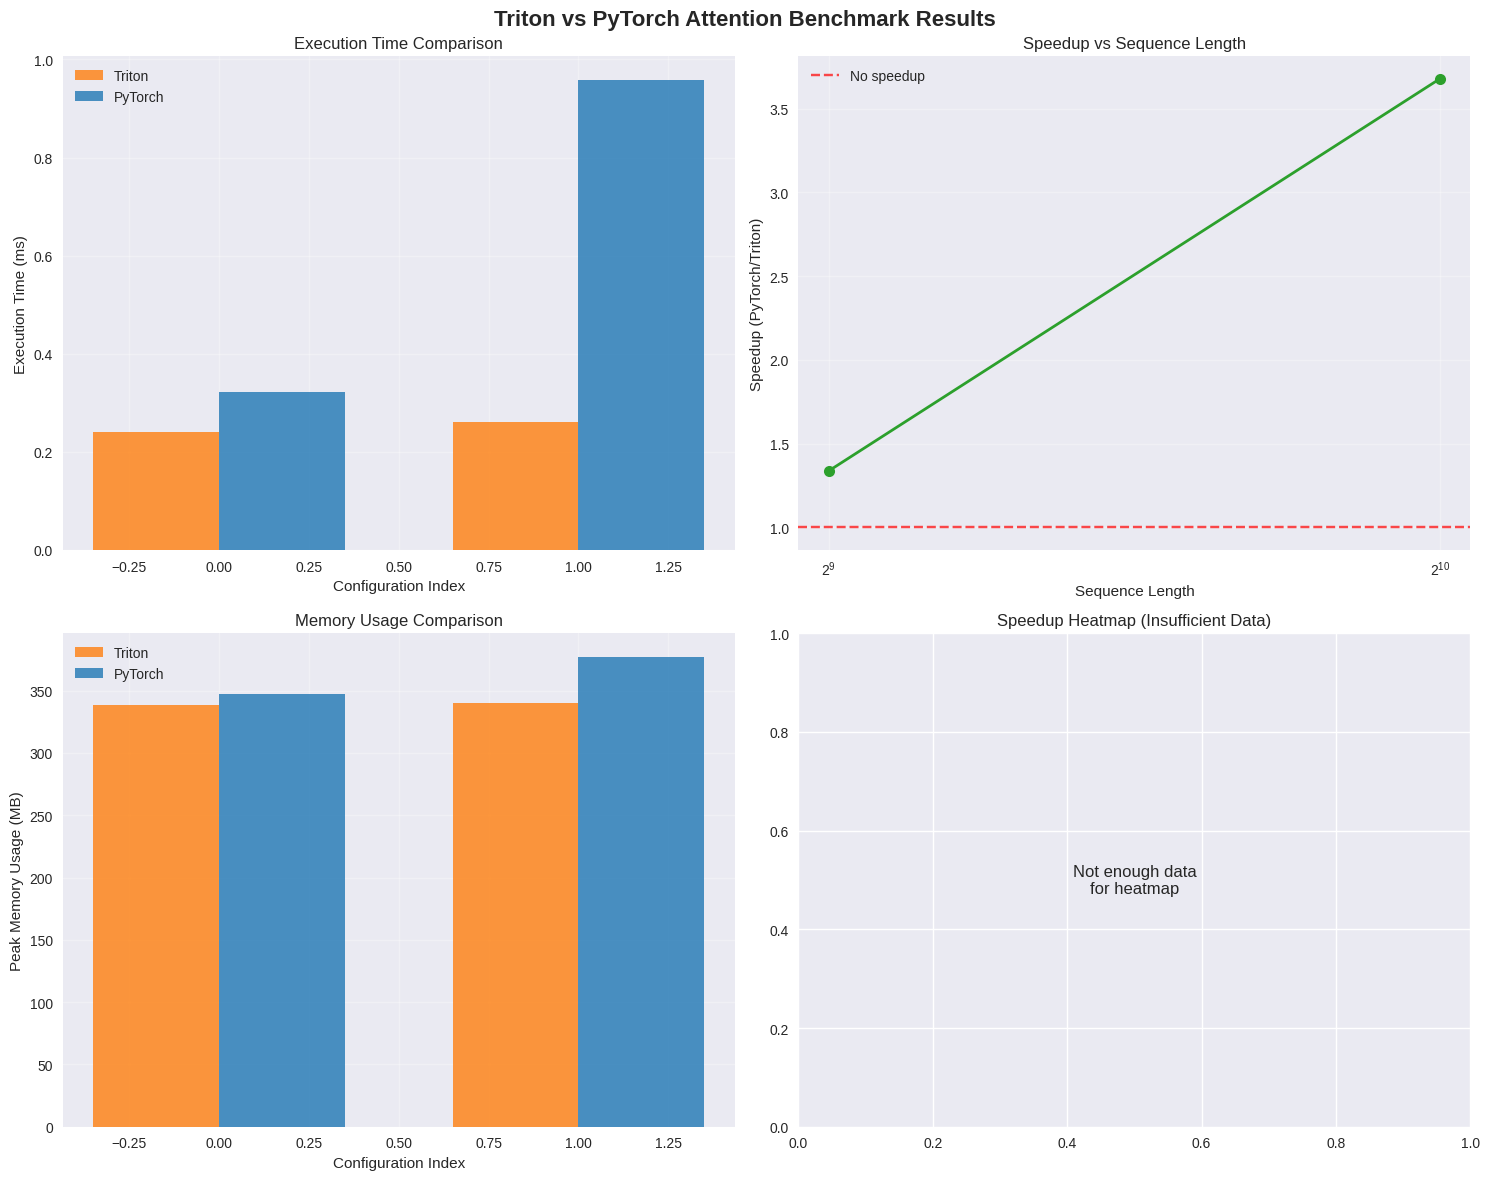

Running comprehensive attention benchmark...

🔥 CAUSAL ATTENTION BENCHMARK
Starting attention benchmarking...
Causal: True, Heads: 8, Trials: 5
------------------------------------------------------------
Testing B=1, S=256, H=64
  Triton: 0.340ms, PyTorch: 0.413ms, Speedup: 1.21x
Testing B=1, S=256, H=128
  Triton: 0.267ms, PyTorch: 0.275ms, Speedup: 1.03x
Testing B=1, S=512, H=64
  Triton: 0.266ms, PyTorch: 0.404ms, Speedup: 1.52x
Testing B=1, S=512, H=128
  Triton: 0.387ms, PyTorch: 0.411ms, Speedup: 1.06x
Testing B=1, S=1024, H=64
  Triton: 0.325ms, PyTorch: 1.060ms, Speedup: 3.26x
Testing B=1, S=1024, H=128
  Triton: 0.610ms, PyTorch: 1.156ms, Speedup: 1.89x
Testing B=1, S=2048, H=64
  Triton: 0.515ms, PyTorch: 5.409ms, Speedup: 10.50x
Testing B=1, S=2048, H=128
  Triton: 1.285ms, PyTorch: 6.436ms, Speedup: 5.01x
Testing B=2, S=256, H=64
  Triton: 0.226ms, PyTorch: 0.277ms, Speedup: 1.22x
Testing B=2, S=256, H=128
  Triton: 0.298ms, PyTorch: 0.284ms, Speedup: 0.95x
Testing B=2, S=

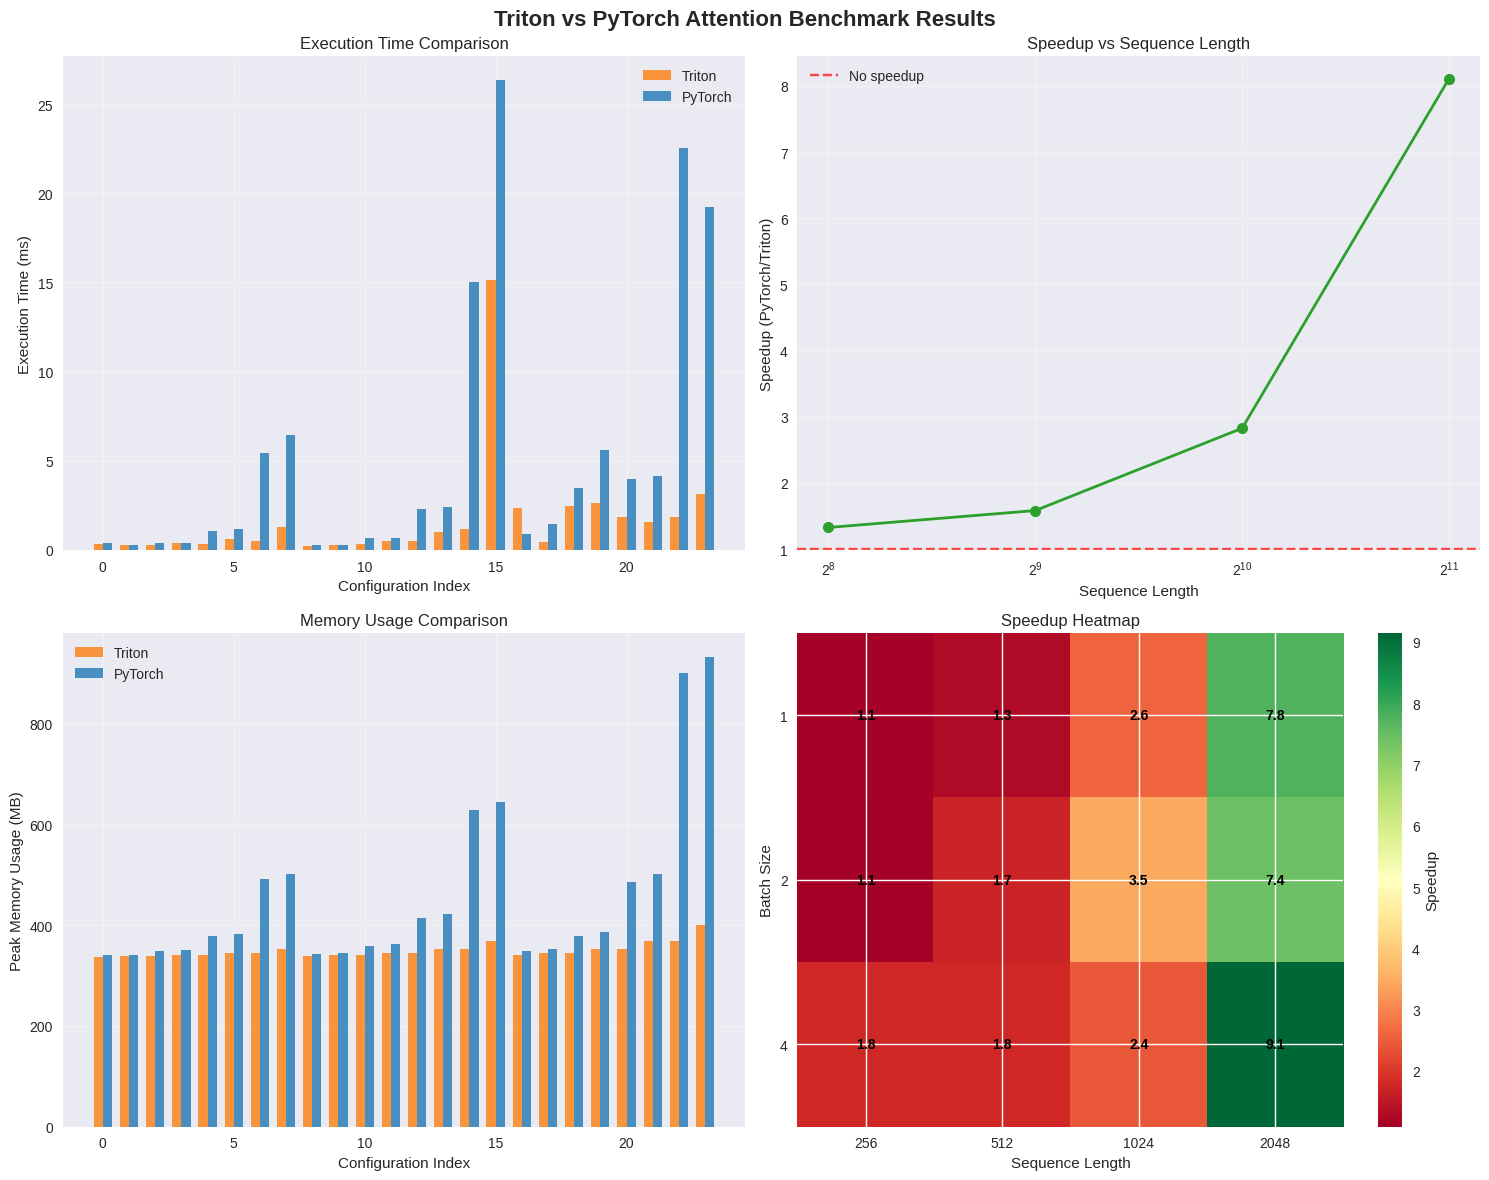


🌐 NON-CAUSAL ATTENTION BENCHMARK
Starting attention benchmarking...
Causal: False, Heads: 8, Trials: 5
------------------------------------------------------------
Testing B=1, S=256, H=64
  Triton: 0.224ms, PyTorch: 0.161ms, Speedup: 0.72x
Testing B=1, S=256, H=128
  Triton: 0.268ms, PyTorch: 0.165ms, Speedup: 0.62x
Testing B=1, S=512, H=64
  Triton: 0.318ms, PyTorch: 0.258ms, Speedup: 0.81x
Testing B=1, S=512, H=128
  Triton: 0.398ms, PyTorch: 0.259ms, Speedup: 0.65x
Testing B=1, S=1024, H=64
  Triton: 0.423ms, PyTorch: 0.700ms, Speedup: 1.65x
Testing B=1, S=1024, H=128
  Triton: 0.853ms, PyTorch: 0.769ms, Speedup: 0.90x
Testing B=2, S=256, H=64
  Triton: 0.238ms, PyTorch: 0.176ms, Speedup: 0.74x
Testing B=2, S=256, H=128
  Triton: 0.411ms, PyTorch: 0.282ms, Speedup: 0.69x
Testing B=2, S=512, H=64
  Triton: 0.304ms, PyTorch: 0.413ms, Speedup: 1.36x
Testing B=2, S=512, H=128
  Triton: 0.536ms, PyTorch: 0.436ms, Speedup: 0.81x
Testing B=2, S=1024, H=64
  Triton: 0.654ms, PyTorch: 1.29

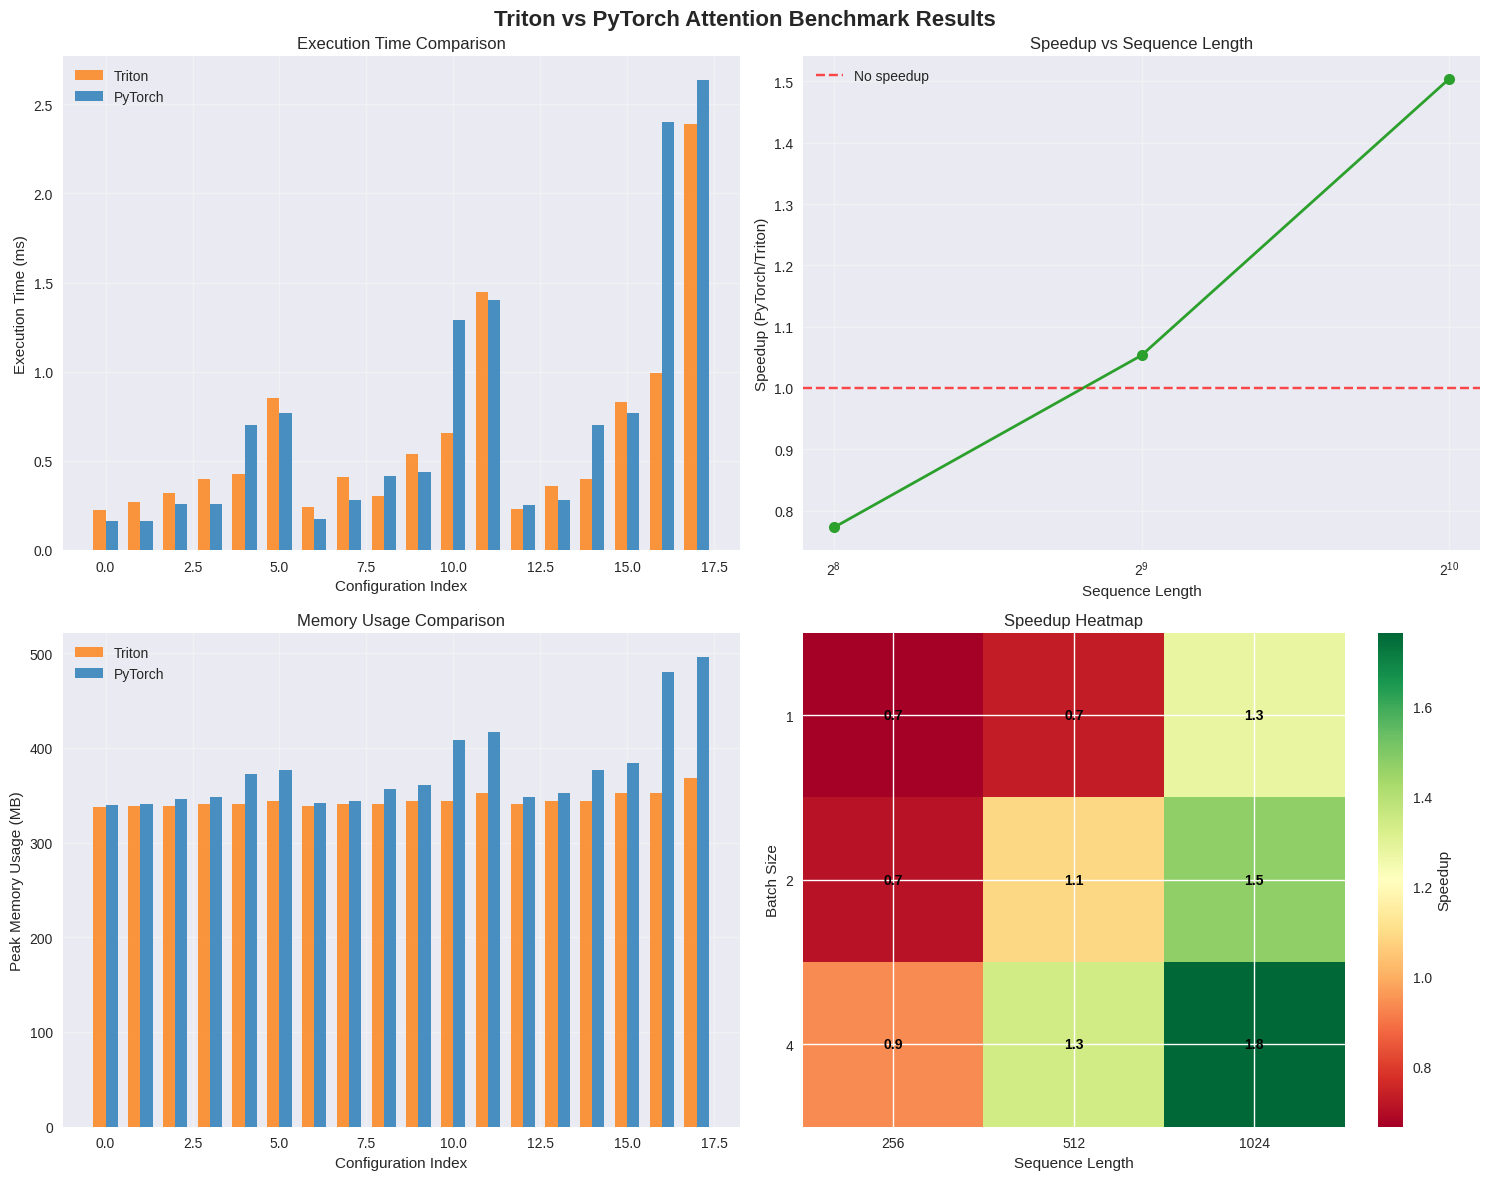


🎉 BENCHMARKING COMPLETE!
Check the generated 'quick_benchmark.png' file for visual results.


In [ ]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict
import seaborn as sns
import triton
import triton.language as tl


# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def pytorch_attention(Q, K, V, causal=False, softmax_scale=None):
    """Standard PyTorch attention implementation"""
    if softmax_scale is None:
        softmax_scale = 1.0 / (Q.shape[-1] ** 0.5)

    # Compute attention scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) * softmax_scale

    # Apply causal mask if needed
    if causal:
        seq_len = Q.shape[-2]
        mask = torch.tril(torch.ones(seq_len, seq_len, device=Q.device))
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Apply softmax
    attn_weights = torch.softmax(scores, dim=-1)

    # Apply attention to values
    output = torch.matmul(attn_weights, V)

    return output


@triton.jit
def _attn_fwd_inner(
    O_block,
    l_i,
    m_i,
    Q_block,
    K_block_ptr,
    V_block_ptr,
    block_index_q,
    softmax_scale,
    BLOCK_SIZE_Q: tl.constexpr,
    BLOCK_SIZE_KV: tl.constexpr,
    STAGE: tl.constexpr,
    offs_q: tl.constexpr,
    offs_kv: tl.constexpr,
    SEQ_LEN: tl.constexpr,
):
    # range of values handled by this stage
    if STAGE == 1:
        # From 0 to the left of the diagonal
        lo, hi = 0, block_index_q * BLOCK_SIZE_Q
    elif STAGE == 2:
        # Used only for the block in which there is transition between non-masked and masked keys
        lo, hi = block_index_q * BLOCK_SIZE_Q, (block_index_q + 1) * BLOCK_SIZE_Q
        lo = tl.multiple_of(lo, BLOCK_SIZE_Q)
    else:
        # Only used for non-causal attention
        lo, hi = 0, SEQ_LEN

    K_block_ptr = tl.advance(K_block_ptr, (0, lo))
    V_block_ptr = tl.advance(V_block_ptr, (lo, 0))

    # loop over k, v and update accumulator
    for start_kv in range(lo, hi, BLOCK_SIZE_KV):
        # Just let the compiler know that start_n is a multiple of BLOCK_N, so the compiler can do optimizations
        start_kv = tl.multiple_of(start_kv, BLOCK_SIZE_KV)

        # -- compute qk ----
        K_block = tl.load(K_block_ptr)
        QK_block = tl.dot(Q_block, K_block)

        if STAGE == 2:
            mask = offs_q[:, None] >= (start_kv + offs_kv[None, :])
            QK_block = QK_block * softmax_scale + tl.where(mask, 0, -1.0e6)
            m_ij = tl.maximum(m_i, tl.max(QK_block, 1))
            QK_block -= m_ij[:, None]
        else:
            # Compute the maximum value of qk or keep the old max value
            m_ij = tl.maximum(m_i, tl.max(QK_block, 1) * softmax_scale)
            QK_block = QK_block * softmax_scale - m_ij[:, None]

        # Compute the exponential of each dot product, so now we are computing exp(qk_ij - m_ij)
        P_block = tl.math.exp(QK_block)
        # Compute the sum by rows of the attention scores
        l_ij = tl.sum(P_block, 1)

        # This is the correction factor for the previous l_i
        alpha = tl.math.exp(m_i - m_ij)
        # Apply the correction factor to the previous l_i and add the new l_ij
        l_i = l_i * alpha + l_ij

        V_block = tl.load(V_block_ptr)
        P_block = P_block.to(tl.float16)
        # This computes the following: O_new = P x V + O_old * alpha
        O_block = O_block * alpha[:, None]
        O_block = tl.dot(P_block, V_block, O_block)

        m_i = m_ij

        # Move to the next block of K and V
        V_block_ptr = tl.advance(V_block_ptr, (BLOCK_SIZE_KV, 0))
        K_block_ptr = tl.advance(K_block_ptr, (0, BLOCK_SIZE_KV))
    return O_block, l_i, m_i

@triton.autotune(
    [
        triton.Config(
            {"BLOCK_SIZE_Q": BLOCK_SIZE_Q, "BLOCK_SIZE_KV": BLOCK_SIZE_KV},
            num_stages=num_stages,
            num_warps=num_warps,
        )
        for BLOCK_SIZE_Q in [64]                 # smaller block to reduce VRAM usage
        for BLOCK_SIZE_KV in [32]                # smaller KV block helps cache fit
        for num_stages in [2, 3]                 # fewer stages = less register pressure
        for num_warps in [2]                     # 2 warps fits better on RTX 3050
    ],
    key=["SEQ_LEN", "HEAD_DIM"],
)

@triton.jit
def _attn_fwd(
    Q,  # BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM
    K,  # BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM
    V,  # BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM
    softmax_scale,
    M,  # BATCH_SIZE, NUM_HEADS, SEQ_LEN
    O,  # BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM
    stride_Q_batch,
    stride_Q_head,
    stride_Q_seq,
    stride_Q_dim,
    stride_K_batch,
    stride_K_head,
    stride_K_seq,
    stride_K_dim,
    stride_V_batch,
    stride_V_head,
    stride_V_seq,
    stride_V_dim,
    stride_O_batch,
    stride_O_head,
    stride_O_seq,
    stride_O_dim,
    BATCH_SIZE,
    NUM_HEADS: tl.constexpr,
    SEQ_LEN: tl.constexpr,
    HEAD_DIM: tl.constexpr,
    BLOCK_SIZE_Q: tl.constexpr,
    BLOCK_SIZE_KV: tl.constexpr,
    STAGE: tl.constexpr,
):
    tl.static_assert(BLOCK_SIZE_KV <= HEAD_DIM)

    # This indicate which block in the sequence length to process
    block_index_q = tl.program_id(0)

    # This indicates which head and batch to process. Each program is associated with a single head of a single batch
    index_batch_head = tl.program_id(1)
    # This indicate which batch this program is associated with (each batch has NUM_HEADS heads)
    index_batch = index_batch_head // NUM_HEADS
    # This indicate the position of the head in the batch
    index_head = index_batch_head % NUM_HEADS

    # This allows to get the (N_CTX, HEAD_DIM) block in the Q, K, V by selecting indexing it by batch and head
    qvk_offset = (
        index_batch.to(tl.int64) * stride_Q_batch
        + index_head.to(tl.int64) * stride_Q_head
    )

    Q_block_ptr = tl.make_block_ptr(
        base=Q + qvk_offset,
        shape=(SEQ_LEN, HEAD_DIM),
        strides=(stride_Q_seq, stride_Q_dim),
        offsets=(block_index_q * BLOCK_SIZE_Q, 0),
        block_shape=(BLOCK_SIZE_Q, HEAD_DIM),
        order=(1, 0),
    )

    V_block_ptr = tl.make_block_ptr(
        base=V + qvk_offset,
        shape=(SEQ_LEN, HEAD_DIM),
        strides=(stride_V_seq, stride_V_dim),
        offsets=(0, 0),
        block_shape=(BLOCK_SIZE_KV, HEAD_DIM),
        order=(1, 0),
    )

    K_block_ptr = tl.make_block_ptr(
        base=K + qvk_offset,
        shape=(HEAD_DIM, SEQ_LEN),
        strides=(
            stride_K_dim,
            stride_K_seq,
        ),  # We invert the strides w.r.t Q, so we transpose the matrix
        offsets=(0, 0),
        block_shape=(HEAD_DIM, BLOCK_SIZE_KV),
        order=(0, 1),
    )

    O_block_ptr = tl.make_block_ptr(
        base=O + qvk_offset,
        shape=(SEQ_LEN, HEAD_DIM),
        strides=(stride_O_seq, stride_O_dim),
        offsets=(block_index_q * BLOCK_SIZE_Q, 0),
        block_shape=(BLOCK_SIZE_Q, HEAD_DIM),
        order=(1, 0),
    )

    # offs_q: the offsets for the tokens in the Q to process
    offs_q = block_index_q * BLOCK_SIZE_Q + tl.arange(0, BLOCK_SIZE_Q)
    # offs_kv: the offsets for the tokens in the K and V sequence to process
    offs_kv = tl.arange(0, BLOCK_SIZE_KV)

    # m_i: the running maximum. We have one for each query
    m_i = tl.zeros([BLOCK_SIZE_Q], dtype=tl.float32) - float("inf")
    # l_i: the running sum. We have one for each query (as we sum the attention scores by rows)
    l_i = tl.zeros([BLOCK_SIZE_Q], dtype=tl.float32) + 1.0
    # acc: the accumulator for the output, which is a group of rows of the O matrix
    O_block = tl.zeros([BLOCK_SIZE_Q, HEAD_DIM], dtype=tl.float32)

    # load the blocks of Q: it will stay in SRAM throughout
    Q_block = tl.load(Q_block_ptr)

    # Stage: 3 if causal, else 1

    if STAGE == 1 or STAGE == 3:
        # This step runs for non-causal attention or for the blocks to the left of the diagonal in the causal attention
        O_block, l_i, m_i = _attn_fwd_inner(
            O_block,
            l_i,
            m_i,
            Q_block,
            K_block_ptr,
            V_block_ptr,
            block_index_q,
            softmax_scale,
            BLOCK_SIZE_Q,
            BLOCK_SIZE_KV,
            4 - STAGE,
            offs_q,
            offs_kv,
            SEQ_LEN,
        )

    if STAGE == 3:
        # This step runs for the blocks to the right of the diagonal in the causal attention
        O_block, l_i, m_i = _attn_fwd_inner(
            O_block,
            l_i,
            m_i,
            Q_block,
            K_block_ptr,
            V_block_ptr,
            block_index_q,
            softmax_scale,
            BLOCK_SIZE_Q,
            BLOCK_SIZE_KV,
            2,
            offs_q,
            offs_kv,
            SEQ_LEN,
        )
    # epilogue
    m_i += tl.math.log(
        l_i
    )  # This is needed to compute the logsumexp for the backwards pass
    O_block = O_block / l_i[:, None]
    m_ptrs = M + index_batch_head * SEQ_LEN + offs_q
    tl.store(m_ptrs, m_i)
    tl.store(O_block_ptr, O_block.to(O.type.element_ty))


@triton.jit
def _attn_bwd_preprocess(
    O,
    dO,
    D,
    SEQ_LEN,
    BLOCK_SIZE_Q: tl.constexpr,
    HEAD_DIM: tl.constexpr,
):
    block_index_q = tl.program_id(0)
    offs_q = block_index_q * BLOCK_SIZE_Q + tl.arange(0, BLOCK_SIZE_Q)
    index_batch_head = tl.program_id(1)
    offs_dim = tl.arange(0, HEAD_DIM)
    # Load a single block of BLOCK_SIZE_Q rows of O
    O_block = tl.load(
        O
        + index_batch_head * HEAD_DIM * SEQ_LEN
        + offs_q[:, None] * HEAD_DIM
        + offs_dim[None, :]
    )
    # Load a single block of BLOCK_SIZE_Q rows of dO
    dO_block = tl.load(
        dO
        + index_batch_head * HEAD_DIM * SEQ_LEN
        + offs_q[:, None] * HEAD_DIM
        + offs_dim[None, :]
    ).to(tl.float32)
    # Compute the D block
    D_block = tl.sum(dO_block * O_block, axis=1)  # Shape: (BLOCK_SIZE_Q,)
    # Store the D block
    D_block_ptrs = D + index_batch_head * SEQ_LEN + offs_q
    tl.store(D_block_ptrs, D_block)


@triton.jit
def _attn_bwd_dq(
    Q,
    K,
    V,
    softmax_scale,
    dO,
    dQ,
    dK,
    dV,
    M,
    D,
    stride_batch,
    stride_head,
    stride_seq,
    stride_dim,
    NUM_HEADS,
    SEQ_LEN,
    BLOCK_Q: tl.constexpr,
    BLOCK_KV: tl.constexpr,
    HEAD_DIM: tl.constexpr,
    STAGE: tl.constexpr,
):
    index_batch_head = tl.program_id(2)
    index_batch = index_batch_head // NUM_HEADS
    index_head = index_batch_head % NUM_HEADS
    offset_batch_head = (stride_batch * index_batch + stride_head * index_head).to(
        tl.int64
    )
    # This is the offset that allows us to select the right sequence given the batch and head.
    offset_batch_head_seq = (index_batch_head * SEQ_LEN).to(tl.int64)

    # Make sure the pointers are in the right place w.r.t batch and head
    # The reason we don't access the blocks through make_block_ptr is because we need to use the range of offsets to apply the masking
    Q += offset_batch_head
    K += offset_batch_head
    V += offset_batch_head
    dO += offset_batch_head
    dQ += offset_batch_head
    dK += offset_batch_head
    dV += offset_batch_head

    # Make sure the pointers are in the right place w.r.t batch, head and sequence
    M += offset_batch_head_seq
    D += offset_batch_head_seq

    # load scales
    offs_dim = tl.arange(0, HEAD_DIM)

    index_block_kv = tl.program_id(0)

    start_q = index_block_kv * BLOCK_Q
    offs_q = start_q + tl.arange(0, BLOCK_Q)

    Q_block = tl.load(Q + offs_q[:, None] * stride_seq + offs_dim[None, :] * stride_dim)
    dQ_block = tl.zeros([BLOCK_Q, HEAD_DIM], dtype=tl.float32)
    dO_block = tl.load(
        dO + offs_q[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    )

    M_block = tl.load(M + offs_q)
    M_block = M_block[:, None]

    offs_kv = tl.arange(0, BLOCK_KV)

    # We access the K and V as transposed blocks
    kT_ptrs = K + offs_kv[None, :] * stride_seq + offs_dim[:, None] * stride_dim
    vT_ptrs = V + offs_kv[None, :] * stride_seq + offs_dim[:, None] * stride_dim

    Di = tl.load(D + offs_q)

    curr_kv = 0
    num_steps = SEQ_LEN // BLOCK_KV
    for blk_idx in range(num_steps):
        K_T_block = tl.load(kT_ptrs)
        V_T_block = tl.load(vT_ptrs)
        QK_block = softmax_scale * tl.dot(Q_block, K_T_block)
        P_block = tl.math.exp(QK_block - M_block)

        if STAGE == 3:
            # Autoregressive masking.
            offs_kv = curr_kv + tl.arange(0, BLOCK_KV)
            mask_block = offs_q[:, None] >= offs_kv[None, :]
            P_block = tl.where(mask_block, P_block, 0.0)

        # Compute dP and dS.
        dP_block = tl.dot(dO_block, V_T_block).to(tl.float32)
        dS_block = P_block * (dP_block - Di[:, None])
        dS_block = dS_block.to(tl.float16)
        # Compute dQ.
        # NOTE: We need to de-scale dq in the end, because kT was pre-scaled.
        dQ_block += softmax_scale * tl.dot(dS_block, tl.trans(K_T_block))
        # Increment pointers.
        curr_kv += BLOCK_KV
        kT_ptrs += BLOCK_KV * stride_seq
        vT_ptrs += BLOCK_KV * stride_seq

    dQ_block_ptrs = dQ + offs_q[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    tl.store(dQ_block_ptrs, dQ_block)


@triton.jit
def _attn_bwd_dk_dv(
    Q,
    K,
    V,
    softmax_scale,
    dO,
    dQ,
    dK,
    dV,
    M,
    D,
    stride_batch,
    stride_head,
    stride_seq,
    stride_dim,
    NUM_HEADS,
    SEQ_LEN,
    BLOCK_Q: tl.constexpr,
    BLOCK_KV: tl.constexpr,
    HEAD_DIM: tl.constexpr,
    STAGE: tl.constexpr,
):
    index_batch_head = tl.program_id(2)
    index_batch = index_batch_head // NUM_HEADS
    index_head = index_batch_head % NUM_HEADS
    offset_batch_head = (stride_batch * index_batch + stride_head * index_head).to(
        tl.int64
    )
    # This is the offset that allows us to select the right sequence given the batch and head.
    offset_batch_head_seq = (index_batch_head * SEQ_LEN).to(tl.int64)

    # Make sure the pointers are in the right place w.r.t batch and head
    # The reason we don't access the blocks through make_block_ptr is because we need to use the range of offsets to apply the masking
    Q += offset_batch_head
    K += offset_batch_head
    V += offset_batch_head
    dO += offset_batch_head
    dQ += offset_batch_head
    dK += offset_batch_head
    dV += offset_batch_head

    # Make sure the pointers are in the right place w.r.t batch, head and sequence
    M += offset_batch_head_seq
    D += offset_batch_head_seq

    # load scales
    offs_dim = tl.arange(0, HEAD_DIM)

    index_block_kv = tl.program_id(0)
    start_kv = index_block_kv * BLOCK_KV

    offs_kv = start_kv + tl.arange(0, BLOCK_KV)

    dV_block = tl.zeros([BLOCK_KV, HEAD_DIM], dtype=tl.float32)
    dK_block = tl.zeros([BLOCK_KV, HEAD_DIM], dtype=tl.float32)

    # load K and V: they stay in SRAM throughout the inner loop.
    K_block = tl.load(
        K + offs_kv[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    )  # Shape: (BLOCK_KV1, HEAD_DIM)
    V_block = tl.load(
        V + offs_kv[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    )  # Shape: (BLOCK_KV1, HEAD_DIM)

    offs_q = tl.arange(0, BLOCK_Q)

    # We access the Q as a transposed array, so that's why we treat offs_q as a column vector ans offs_dim as a row vector
    # This is equivalent to doing:
    # q_ptrs = Q + offs_q[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    # qT_ptrs = tl.trans(q_ptrs)
    # We point to the first BLOCK_Q rows of Q for both the qT and dO pointers, inside the for loop we will move forward by BLOCK_Q rows at each iteration.
    qT_ptrs = Q + offs_q[None, :] * stride_seq + offs_dim[:, None] * stride_dim
    dO_ptrs = dO + offs_q[:, None] * stride_seq + offs_dim[None, :] * stride_dim

    # Iterates over the sequence dimension of the query
    curr_q = 0
    num_steps = SEQ_LEN // BLOCK_Q
    for blk_idx in range(num_steps):
        # Load a block of Q
        qT_block = tl.load(qT_ptrs)
        # Load the logsumexp values for the queries in the current block
        offs_q = curr_q + tl.arange(0, BLOCK_Q)
        m = tl.load(M + offs_q)

        # This gives us (QK^T)^T = (K^T)^T(Q^T) = K(Q^T) = P^T
        QK_T_block = softmax_scale * tl.dot(K_block, qT_block)
        # We apply the softmax by using the logsumexp trick
        P_T_block = tl.math.exp(QK_T_block - m[None, :])

        if STAGE == 3:
            # Autoregressive masking.
            # mask is True for all values that DO NOT NEED TO BE MASKED
            mask_block = (
                offs_q[None, :] >= offs_kv[:, None]
            )  # Shape: (BLOCK_KV1, BLOCK_Q1)
            # Replace all the masked values with 0.
            # In this case we do not need to mask with -Inf before applying the softmax since we already computed the normalization factors (stored in "m")
            P_T_block = tl.where(mask_block, P_T_block, 0.0)

        dO_block = tl.load(dO_ptrs)
        # According to the formula: dV_new = dV_old + P^T x dO, where x is the matrix multiplication
        dV_block += tl.dot(P_T_block.to(tl.float16), dO_block)

        # Delta = rowsum(O * dO) where * is the element-wise product
        Di = tl.load(D + offs_q)

        # dP = dO x V^T, so dP^T = V x dO^T
        # Where x is the matrix multiplication
        dpT_block = tl.dot(V_block, tl.trans(dO_block)).to(tl.float32)

        # We know that dS = P * (dP - Delta), so dS^T = P^T * (dP^T - Delta^T)

        dS_T_block = P_T_block * (dpT_block - Di[None, :])
        dS_T_block = dS_T_block.to(tl.float16)

        # According to the formula on the paper: dK_new = dK_old + dS^T x Q
        dK_block += softmax_scale * tl.dot(dS_T_block, tl.trans(qT_block))
        # Increment pointers.
        curr_q += BLOCK_Q
        qT_ptrs += BLOCK_Q * stride_seq
        dO_ptrs += BLOCK_Q * stride_seq

    # Write back dV.
    dV_block_ptrs = dV + offs_kv[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    tl.store(dV_block_ptrs, dV_block)

    # Write back dK.
    dK_block_ptrs = dK + offs_kv[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    tl.store(dK_block_ptrs, dK_block)


class TritonAttention(torch.autograd.Function):

    @staticmethod
    def forward(ctx, Q, K, V, causal, softmax_scale):
        HEAD_DIM_Q, HEAD_DIM_K = Q.shape[-1], K.shape[-1]
        HEAD_DIM_V = V.shape[-1]

        BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM = Q.shape

        assert HEAD_DIM_Q == HEAD_DIM_K and HEAD_DIM_K == HEAD_DIM_V

        O = torch.empty_like(Q)
        stage = 3 if causal else 1

        grid = lambda args: (
            triton.cdiv(SEQ_LEN, args["BLOCK_SIZE_Q"]),
            BATCH_SIZE * NUM_HEADS,
            1,
        )

        # M is the logsumexp for the backward pass, one for each query
        M = torch.empty(
            (BATCH_SIZE, NUM_HEADS, SEQ_LEN), device=Q.device, dtype=torch.float32
        )

        _attn_fwd[grid](
            Q=Q,
            K=K,
            V=V,
            softmax_scale=softmax_scale,
            M=M,
            O=O,
            stride_Q_batch=Q.stride(0),
            stride_Q_head=Q.stride(1),
            stride_Q_seq=Q.stride(2),
            stride_Q_dim=Q.stride(3),
            stride_K_batch=K.stride(0),
            stride_K_head=K.stride(1),
            stride_K_seq=K.stride(2),
            stride_K_dim=K.stride(3),
            stride_V_batch=V.stride(0),
            stride_V_head=V.stride(1),
            stride_V_seq=V.stride(2),
            stride_V_dim=V.stride(3),
            stride_O_batch=O.stride(0),
            stride_O_head=O.stride(1),
            stride_O_seq=O.stride(2),
            stride_O_dim=O.stride(3),
            BATCH_SIZE=Q.shape[0],
            NUM_HEADS=Q.shape[1],
            SEQ_LEN=Q.shape[2],
            HEAD_DIM=HEAD_DIM_K,
            STAGE=stage,
        )

        ctx.save_for_backward(Q, K, V, O, M)
        ctx.grid = grid
        ctx.softmax_scale = softmax_scale
        ctx.HEAD_DIM = HEAD_DIM_K
        ctx.causal = causal
        return O

    @staticmethod
    def backward(ctx, dO):
        Q, K, V, O, M = ctx.saved_tensors

        assert dO.is_contiguous()
        assert Q.stride() == K.stride() == V.stride() == O.stride() == dO.stride()
        dQ = torch.empty_like(Q)
        dK = torch.empty_like(K)
        dV = torch.empty_like(V)

        BATCH_SIZE, NUM_HEADS, SEQ_LEN = Q.shape[:3]
        NUM_WARPS, NUM_STAGES = 4, 3
        BLOCK_SIZE_MICRO, BLOCK_SIZE_MACRO = 32, 128

        preprocess_grid = (SEQ_LEN // BLOCK_SIZE_MACRO, BATCH_SIZE * NUM_HEADS)
        D = torch.empty_like(M)  # Shape: (BATCH_SIZE, NUM_HEADS, SEQ_LEN)

        # Compute all the elements Di
        _attn_bwd_preprocess[preprocess_grid](
            O=O,
            dO=dO,
            D=D,
            SEQ_LEN=SEQ_LEN,
            BLOCK_SIZE_Q=BLOCK_SIZE_MACRO,
            HEAD_DIM=ctx.HEAD_DIM,
        )

        grid = (SEQ_LEN // BLOCK_SIZE_MACRO, 1, BATCH_SIZE * NUM_HEADS)

        stage = 3 if ctx.causal else 1

        # Fix KV and iterate through all the Q blocks
        _attn_bwd_dk_dv[grid](
            Q=Q,
            K=K,
            V=V,
            softmax_scale=ctx.softmax_scale,
            dO=dO,
            dQ=dQ,
            dK=dK,
            dV=dV,
            M=M,
            D=D,
            stride_batch=Q.stride(0),
            stride_head=Q.stride(1),
            stride_seq=Q.stride(2),
            stride_dim=Q.stride(3),
            NUM_HEADS=NUM_HEADS,
            SEQ_LEN=SEQ_LEN,
            BLOCK_Q=BLOCK_SIZE_MICRO,
            BLOCK_KV=BLOCK_SIZE_MACRO,
            HEAD_DIM=ctx.HEAD_DIM,
            STAGE=stage,
            num_warps=NUM_WARPS,
            num_stages=NUM_STAGES,
        )

        # Fix Q and iterate through all the KV block
        _attn_bwd_dq[grid](
            Q=Q,
            K=K,
            V=V,
            softmax_scale=ctx.softmax_scale,
            dO=dO,
            dQ=dQ,
            dK=dK,
            dV=dV,
            M=M,
            D=D,
            stride_batch=Q.stride(0),
            stride_head=Q.stride(1),
            stride_seq=Q.stride(2),
            stride_dim=Q.stride(3),
            NUM_HEADS=NUM_HEADS,
            SEQ_LEN=SEQ_LEN,
            BLOCK_Q=BLOCK_SIZE_MACRO,
            BLOCK_KV=BLOCK_SIZE_MICRO,
            HEAD_DIM=ctx.HEAD_DIM,
            STAGE=stage,
            num_warps=NUM_WARPS,
            num_stages=NUM_STAGES,
        )

        return dQ, dK, dV, None, None


def test_op(BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM, causal, dtype=torch.float16):
    Q = (
        torch.empty(
            (BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM), dtype=dtype, device="cuda"
        )
        .normal_(mean=0.0, std=0.5)
        .requires_grad_()
    )
    K = (
        torch.empty(
            (BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM), dtype=dtype, device="cuda"
        )
        .normal_(mean=0.0, std=0.5)
        .requires_grad_()
    )
    V = (
        torch.empty(
            (BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM), dtype=dtype, device="cuda"
        )
        .normal_(mean=0.0, std=0.5)
        .requires_grad_()
    )

    softmax_scale = 1 / (HEAD_DIM**0.5)
    dO = torch.randn_like(Q)

    # reference implementation
    MASK = torch.tril(torch.ones((SEQ_LEN, SEQ_LEN), device="cuda"))
    P = torch.matmul(Q, K.transpose(2, 3)) * softmax_scale
    if causal:
        P[:, :, MASK == 0] = float("-inf")
    P = torch.softmax(P.float(), dim=-1).half()
    ref_O = torch.matmul(P, V)
    ref_O.backward(dO)
    ref_dV, V.grad = V.grad.clone(), None
    ref_dK, K.grad = K.grad.clone(), None
    ref_dQ, Q.grad = Q.grad.clone(), None

    # triton implementation
    tri_out = TritonAttention.apply(Q, K, V, causal, softmax_scale).half()
    tri_out.backward(dO)
    tri_dV, V.grad = V.grad.clone(), None
    tri_dK, K.grad = K.grad.clone(), None
    tri_dQ, Q.grad = Q.grad.clone(), None

    # compare
    rtol = 0.0
    atol = 1e-2
    assert torch.allclose(ref_O, tri_out, atol=atol, rtol=rtol)
    assert torch.allclose(ref_dK, tri_dK, atol=atol, rtol=rtol)
    assert torch.allclose(ref_dV, tri_dV, atol=atol, rtol=rtol)
    assert torch.allclose(ref_dQ, tri_dQ, atol=atol, rtol=rtol)


def benchmark_single_method(method_func, num_warmup: int, num_trials: int) -> Tuple[float, float]:
    """Benchmark a single attention method"""
    torch.cuda.synchronize()

    # Warmup
    for _ in range(num_warmup):
        _ = method_func()
        torch.cuda.synchronize()

    # Measure memory before
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    # Timing trials
    times = []
    for _ in range(num_trials):
        torch.cuda.synchronize()
        start_time = time.perf_counter()

        _ = method_func()

        torch.cuda.synchronize()
        end_time = time.perf_counter()

        times.append((end_time - start_time) * 1000)  # Convert to milliseconds

    # Get peak memory usage
    peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # Convert to MB

    return np.mean(times), peak_memory

def benchmark_attention_methods(
    batch_sizes: List[int] = [1, 2, 4],
    seq_lengths: List[int] = [256, 512, 1024, 2048],
    head_dims: List[int] = [64, 128],
    num_heads: int = 8,
    causal: bool = True,
    num_warmup: int = 5,
    num_trials: int = 10,
    dtype: torch.dtype = torch.float16
) -> Dict:
    """
    Benchmark Triton vs PyTorch attention implementations
    """
    results = {
        'triton_times': [],
        'pytorch_times': [],
        'triton_memory': [],
        'pytorch_memory': [],
        'speedup': [],
        'configs': []
    }

    print("Starting attention benchmarking...")
    print(f"Causal: {causal}, Heads: {num_heads}, Trials: {num_trials}")
    print("-" * 60)

    for batch_size in batch_sizes:
        for seq_len in seq_lengths:
            for head_dim in head_dims:
                config = {
                    'batch_size': batch_size,
                    'seq_len': seq_len,
                    'head_dim': head_dim,
                    'num_heads': num_heads
                }

                print(f"Testing B={batch_size}, S={seq_len}, H={head_dim}")

                # Create test tensors
                Q = torch.randn(batch_size, num_heads, seq_len, head_dim,
                              dtype=dtype, device='cuda', requires_grad=True)
                K = torch.randn(batch_size, num_heads, seq_len, head_dim,
                              dtype=dtype, device='cuda', requires_grad=True)
                V = torch.randn(batch_size, num_heads, seq_len, head_dim,
                              dtype=dtype, device='cuda', requires_grad=True)

                softmax_scale = 1.0 / (head_dim ** 0.5)

                # Benchmark Triton implementation
                triton_time, triton_memory = benchmark_single_method(
                    lambda: TritonAttention.apply(Q, K, V, causal, softmax_scale),
                    num_warmup, num_trials
                )

                # Benchmark PyTorch implementation
                pytorch_time, pytorch_memory = benchmark_single_method(
                    lambda: pytorch_attention(Q, K, V, causal, softmax_scale),
                    num_warmup, num_trials
                )

                speedup = pytorch_time / triton_time if triton_time > 0 else 0

                # Store results
                results['triton_times'].append(triton_time)
                results['pytorch_times'].append(pytorch_time)
                results['triton_memory'].append(triton_memory)
                results['pytorch_memory'].append(pytorch_memory)
                results['speedup'].append(speedup)
                results['configs'].append(config)

                print(f"  Triton: {triton_time:.3f}ms, PyTorch: {pytorch_time:.3f}ms, "
                      f"Speedup: {speedup:.2f}x")

                # Clear GPU memory
                torch.cuda.empty_cache()

    return results

def plot_benchmark_results(results: Dict, save_path: str = None):
    """Create comprehensive plots of benchmark results"""

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Triton vs PyTorch Attention Benchmark Results', fontsize=16, fontweight='bold')

    configs = results['configs']
    seq_lens = [c['seq_len'] for c in configs]

    # Plot 1: Execution Time Comparison
    ax1 = axes[0, 0]
    x_pos = np.arange(len(configs))
    width = 0.35

    ax1.bar(x_pos - width/2, results['triton_times'], width,
            label='Triton', alpha=0.8, color='#ff7f0e')
    ax1.bar(x_pos + width/2, results['pytorch_times'], width,
            label='PyTorch', alpha=0.8, color='#1f77b4')

    ax1.set_xlabel('Configuration Index')
    ax1.set_ylabel('Execution Time (ms)')
    ax1.set_title('Execution Time Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Speedup vs Sequence Length
    ax2 = axes[0, 1]
    unique_seq_lens = sorted(list(set(seq_lens)))
    speedup_by_seq_len = {}

    for seq_len in unique_seq_lens:
        speedups = [results['speedup'][i] for i, c in enumerate(configs)
                   if c['seq_len'] == seq_len]
        speedup_by_seq_len[seq_len] = np.mean(speedups)

    ax2.plot(list(speedup_by_seq_len.keys()), list(speedup_by_seq_len.values()),
             'o-', linewidth=2, markersize=8, color='#2ca02c')
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No speedup')
    ax2.set_xlabel('Sequence Length')
    ax2.set_ylabel('Speedup (PyTorch/Triton)')
    ax2.set_title('Speedup vs Sequence Length')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log', base=2)

    # Plot 3: Memory Usage Comparison
    ax3 = axes[1, 0]
    ax3.bar(x_pos - width/2, results['triton_memory'], width,
            label='Triton', alpha=0.8, color='#ff7f0e')
    ax3.bar(x_pos + width/2, results['pytorch_memory'], width,
            label='PyTorch', alpha=0.8, color='#1f77b4')

    ax3.set_xlabel('Configuration Index')
    ax3.set_ylabel('Peak Memory Usage (MB)')
    ax3.set_title('Memory Usage Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Performance Heatmap
    ax4 = axes[1, 1]

    # Create heatmap data
    unique_batch_sizes = sorted(list(set(c['batch_size'] for c in configs)))
    unique_seq_lens = sorted(list(set(c['seq_len'] for c in configs)))

    if len(unique_batch_sizes) > 1 and len(unique_seq_lens) > 1:
        heatmap_data = np.zeros((len(unique_batch_sizes), len(unique_seq_lens)))

        for i, batch_size in enumerate(unique_batch_sizes):
            for j, seq_len in enumerate(unique_seq_lens):
                speedups = [results['speedup'][k] for k, c in enumerate(configs)
                           if c['batch_size'] == batch_size and c['seq_len'] == seq_len]
                if speedups:
                    heatmap_data[i, j] = np.mean(speedups)

        im = ax4.imshow(heatmap_data, cmap='RdYlGn', aspect='auto')
        ax4.set_xticks(range(len(unique_seq_lens)))
        ax4.set_yticks(range(len(unique_batch_sizes)))
        ax4.set_xticklabels(unique_seq_lens)
        ax4.set_yticklabels(unique_batch_sizes)
        ax4.set_xlabel('Sequence Length')
        ax4.set_ylabel('Batch Size')
        ax4.set_title('Speedup Heatmap')

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax4)
        cbar.set_label('Speedup')

        # Add text annotations
        for i in range(len(unique_batch_sizes)):
            for j in range(len(unique_seq_lens)):
                text = ax4.text(j, i, f'{heatmap_data[i, j]:.1f}',
                               ha="center", va="center", color="black", fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Not enough data\nfor heatmap',
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Speedup Heatmap (Insufficient Data)')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

def print_benchmark_summary(results: Dict):
    """Print a summary of benchmark results"""
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY")
    print("="*60)

    avg_triton_time = np.mean(results['triton_times'])
    avg_pytorch_time = np.mean(results['pytorch_times'])
    avg_speedup = np.mean(results['speedup'])
    max_speedup = np.max(results['speedup'])
    min_speedup = np.min(results['speedup'])

    avg_triton_memory = np.mean(results['triton_memory'])
    avg_pytorch_memory = np.mean(results['pytorch_memory'])

    print(f"Average Execution Time:")
    print(f"  Triton:  {avg_triton_time:.3f} ms")
    print(f"  PyTorch: {avg_pytorch_time:.3f} ms")
    print(f"\nSpeedup Statistics:")
    print(f"  Average: {avg_speedup:.2f}x")
    print(f"  Maximum: {max_speedup:.2f}x")
    print(f"  Minimum: {min_speedup:.2f}x")
    print(f"\nAverage Memory Usage:")
    print(f"  Triton:  {avg_triton_memory:.1f} MB")
    print(f"  PyTorch: {avg_pytorch_memory:.1f} MB")
    print(f"  Memory Ratio: {avg_pytorch_memory/avg_triton_memory:.2f}x")

    # Find best performing configuration
    best_speedup_idx = np.argmax(results['speedup'])
    best_config = results['configs'][best_speedup_idx]

    print(f"\nBest Configuration:")
    print(f"  Batch Size: {best_config['batch_size']}")
    print(f"  Sequence Length: {best_config['seq_len']}")
    print(f"  Head Dimension: {best_config['head_dim']}")
    print(f"  Speedup: {results['speedup'][best_speedup_idx]:.2f}x")

    print("="*60)

def quick_benchmark_example():
    """Quick benchmark example with smaller configurations"""
    print("Running quick benchmark example...")

    results = benchmark_attention_methods(
        batch_sizes=[2],
        seq_lengths=[512, 1024],
        head_dims=[64],
        num_heads=4,
        causal=True,
        num_warmup=2,
        num_trials=3
    )

    print_benchmark_summary(results)
    plot_benchmark_results(results, 'quick_benchmark.png')

    return results

def run_comprehensive_benchmark():
    """Run a comprehensive benchmark with various configurations"""

    # Test configurations
    batch_sizes = [1, 2, 4]
    seq_lengths = [256, 512, 1024, 2048]
    head_dims = [64, 128]

    print("Running comprehensive attention benchmark...")

    # Run benchmark for causal attention
    print("\n🔥 CAUSAL ATTENTION BENCHMARK")
    causal_results = benchmark_attention_methods(
        batch_sizes=batch_sizes,
        seq_lengths=seq_lengths,
        head_dims=head_dims,
        num_heads=8,
        causal=True,
        num_warmup=3,
        num_trials=5
    )

    # Print summary and plot results
    print_benchmark_summary(causal_results)
    plot_benchmark_results(causal_results, 'causal_attention_benchmark.png')

    # Run benchmark for non-causal attention
    print("\n🌐 NON-CAUSAL ATTENTION BENCHMARK")
    non_causal_results = benchmark_attention_methods(
        batch_sizes=batch_sizes,
        seq_lengths=seq_lengths[:3],  # Smaller set for non-causal
        head_dims=head_dims,
        num_heads=8,
        causal=False,
        num_warmup=3,
        num_trials=5
    )

    print_benchmark_summary(non_causal_results)
    plot_benchmark_results(non_causal_results, 'non_causal_attention_benchmark.png')

    return causal_results, non_causal_results


if __name__ == "__main__":
    # First run correctness tests
    print("🧪 RUNNING CORRECTNESS TESTS...")
    test_op(BATCH_SIZE=2, NUM_HEADS=4, SEQ_LEN=1024, HEAD_DIM=64, causal=True)
    test_op(BATCH_SIZE=2, NUM_HEADS=4, SEQ_LEN=1024, HEAD_DIM=64, causal=False)
    print("✅ CORRECTNESS TESTS PASSED")

    # Now run benchmarks
    print("\n" + "="*60)
    print("🚀 STARTING PERFORMANCE BENCHMARKS")
    print("="*60)

    # Quick benchmark (recommended to start with)
    results = quick_benchmark_example()
    RESULTS_2=run_comprehensive_benchmark()

    print("\n🎉 BENCHMARKING COMPLETE!")
    print("Check the generated 'quick_benchmark.png' file for visual results.")